# CLASIFICACIÓN DE IMÁGENES BIOMEDICAS PARA EL RECONOCIMIENTO Y DETECCIÓN DE GLIOBLASTOMAS EN EL TEJIDO CEREBRAL

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import skimage.io as io
from glob import glob
import os
import numpy as np
import random as r
import scipy.misc
from scipy import ndimage
import cv2
from numba import jit, cuda

from keras.models import Model
from keras.layers import (
    Dense, 
    Dropout, 
    Activation, 
    Flatten, 
    concatenate, 
    Conv2D, 
    MaxPooling2D, 
    Conv2DTranspose,
    Cropping2D,
    ZeroPadding2D)
from keras.layers import Input,  UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint,CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

import import_ipynb
import funciones as fn
import import_ipynb
import modelo_UNet as modelo

importing Jupyter notebook from funciones.ipynb
importing Jupyter notebook from modelo_UNet.ipynb


## Carga de datos  MICCAI BraTS 2018 

Carga de datos del reposotorio local provenientes de https://www.med.upenn.edu/sbia/brats2018/data.html

https://www.cbica.upenn.edu/sbia/Spyridon.Bakas/MICCAI_BraTS/2018/MICCAI_BraTS_2018_Data_Training.zip

Datos de prueba para mostrar el contenido de imágenes de las carpetas 

In [2]:
rutaA = "data/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_201_1/"
files_aux = glob(rutaA + "**/*.nii.gz", recursive=True)
files_aux

['data/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_201_1/Brats18_TCIA01_201_1_flair.nii.gz',
 'data/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_201_1/Brats18_TCIA01_201_1_t2.nii.gz',
 'data/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_201_1/Brats18_TCIA01_201_1_seg.nii.gz',
 'data/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_201_1/Brats18_TCIA01_201_1_t1.nii.gz',
 'data/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA01_201_1/Brats18_TCIA01_201_1_t1ce.nii.gz']

### Lectura de los archivos comprimidos y muestra de imágenes

In [3]:
img_flair = io.imread(rutaA + 'Brats18_TCIA01_201_1_flair.nii', plugin="simpleitk")
img_t2 =    io.imread(rutaA + 'Brats18_TCIA01_201_1_t2.nii', plugin="simpleitk")
img_seg =   io.imread(rutaA + 'Brats18_TCIA01_201_1_seg.nii', plugin="simpleitk")
img_t1 =    io.imread(rutaA + 'Brats18_TCIA01_201_1_t1.nii', plugin="simpleitk")
img_t1ce =  io.imread(rutaA + 'Brats18_TCIA01_201_1_t1ce.nii', plugin="simpleitk")

img_completo_004 = np.stack((img_flair,img_t1ce,img_t1,img_t2),axis = 3)

In [4]:
img_completo_004.shape,img_t1ce.shape

((155, 240, 240, 4), (155, 240, 240))

Cada archivo contiene los tres planos anatómicos con 155 cortes en imágenes de 240 x 240 pixeles, cada archivo captura atributos distintos al momento de realizar la resonancia. 

En las imágenes se muestran los tres planos anatómicos en cortes donde se identifico la presencia de tejido tumoral. Se realiza también una rotación de cada una de las imágenes para una mejor visualización.

profundidad 80
profundidad segmentación 150


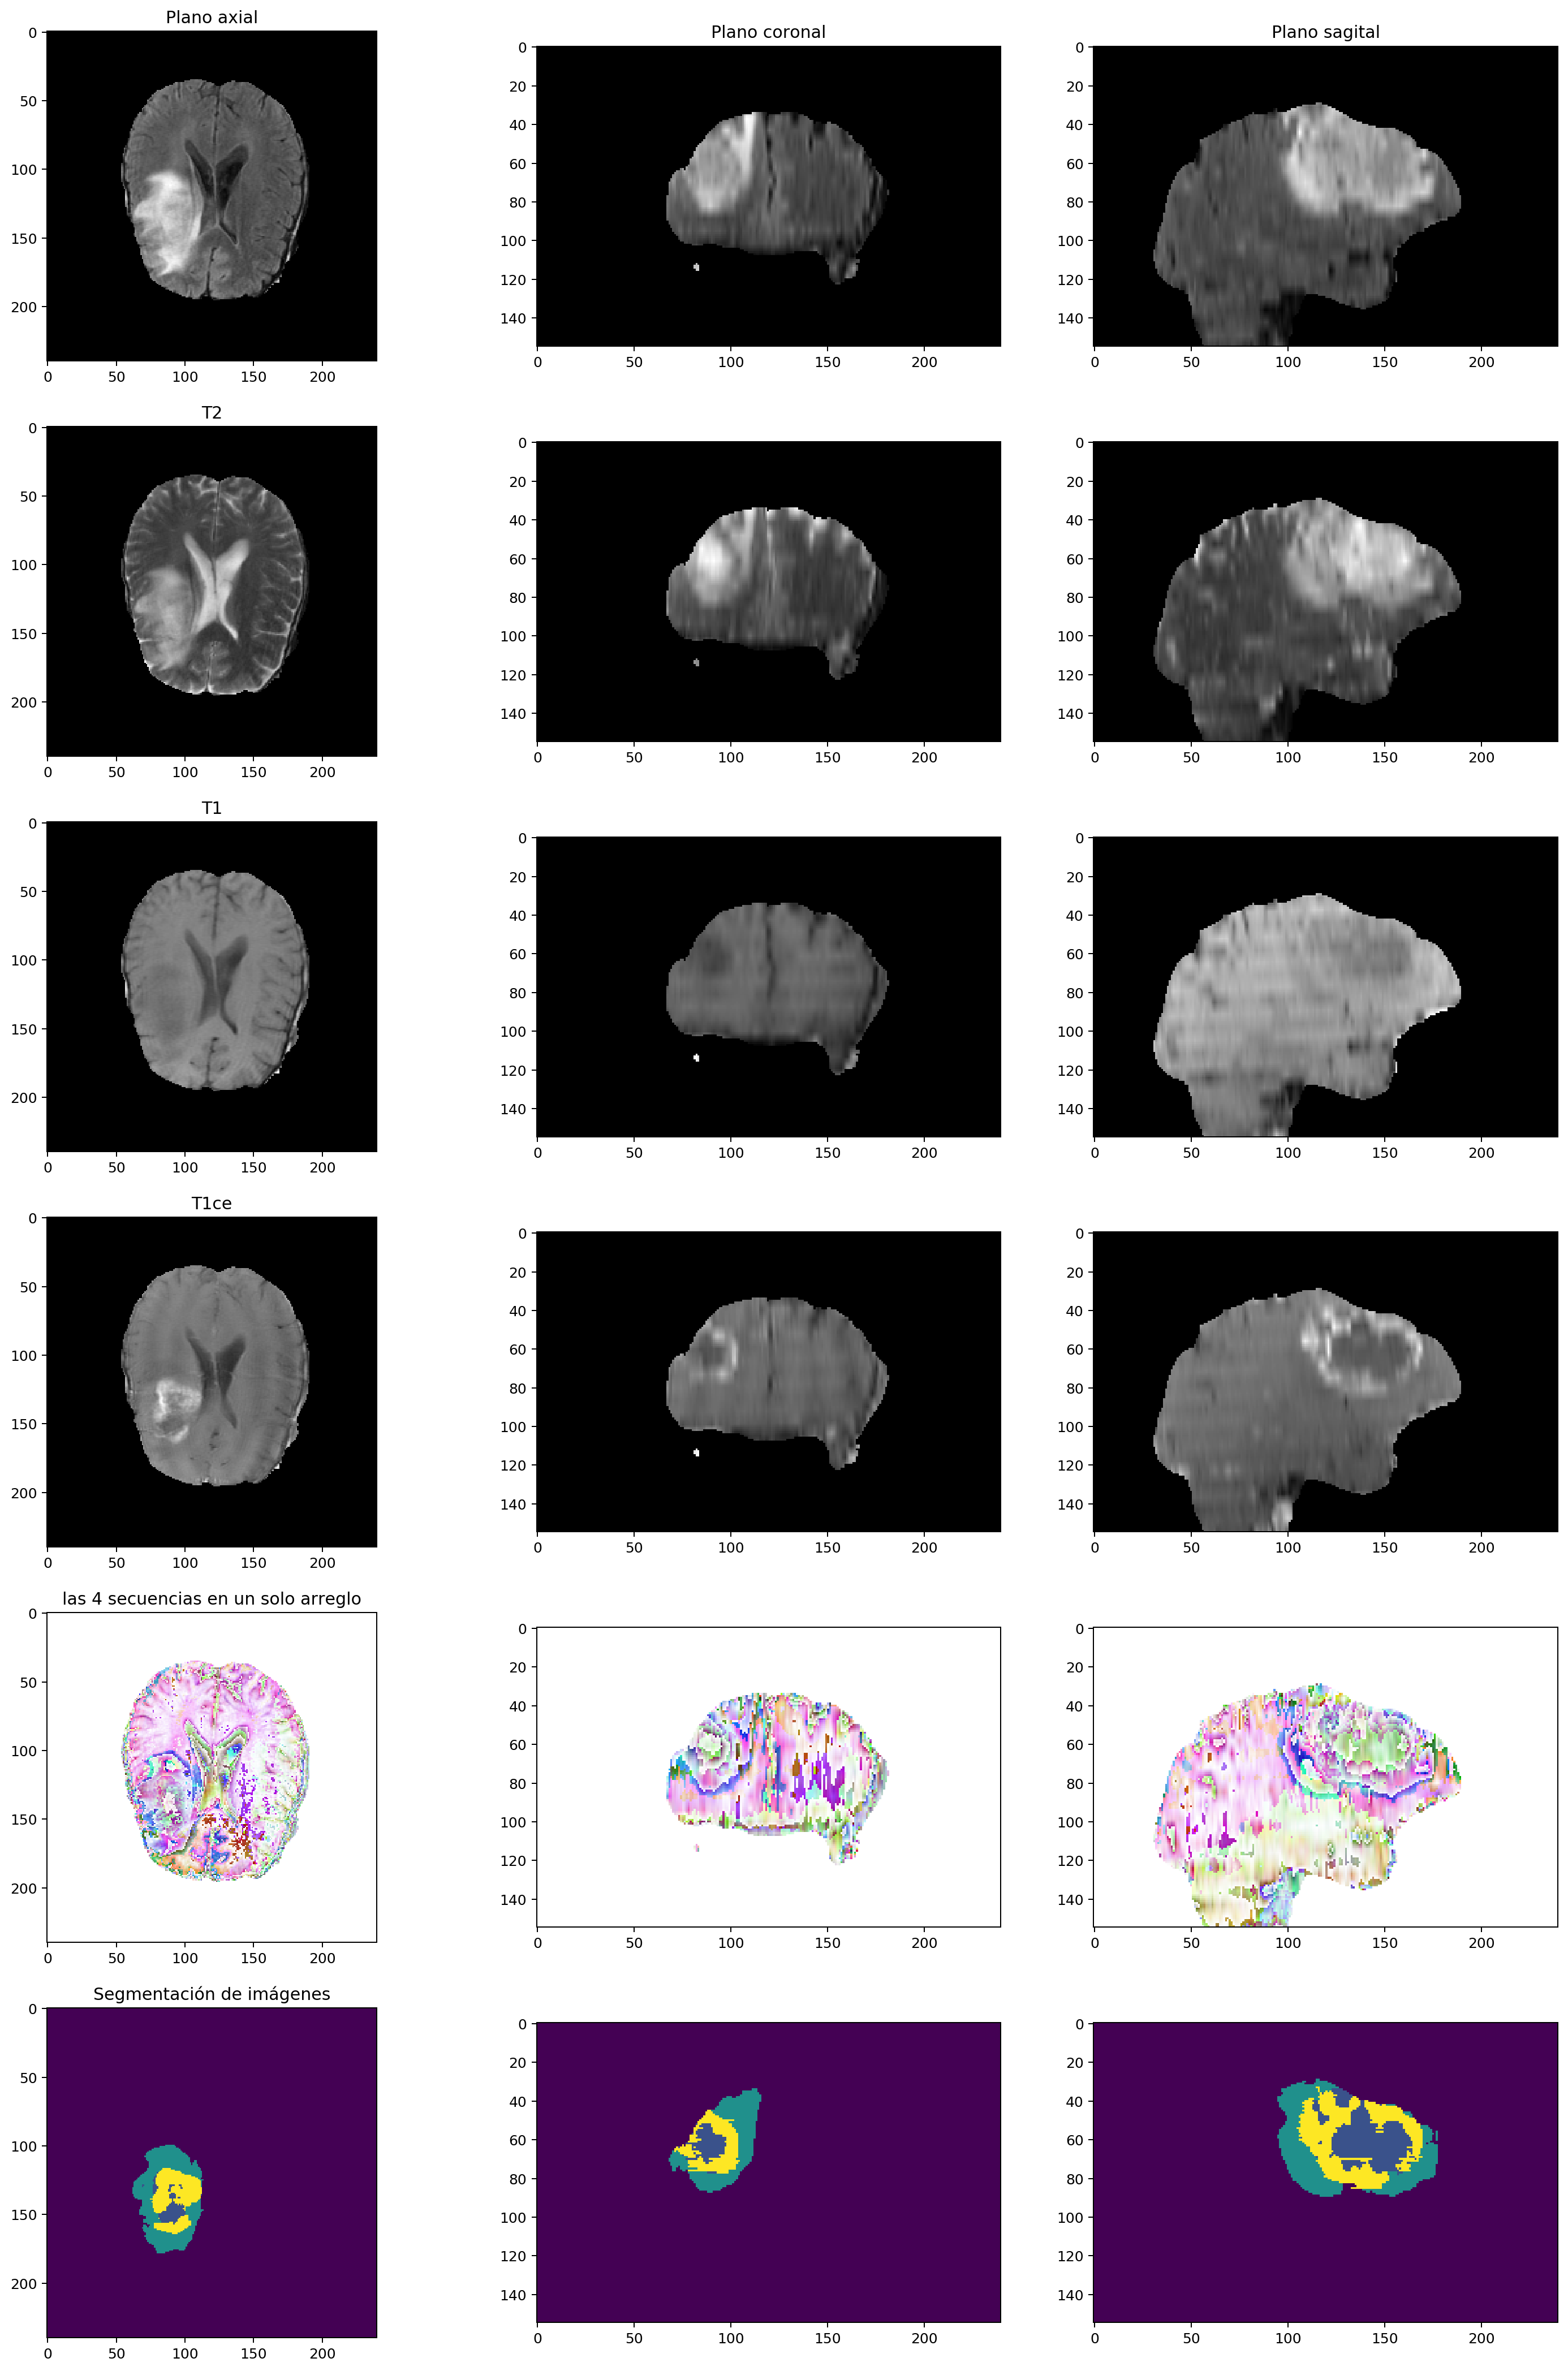

In [5]:
fn.mostrar_img(img_flair,img_t2,img_t1,img_t1ce,img_completo_004,img_seg,80,150)

 ### Visualizamos las distintas secuencias del arreglo completo con los cuatro archivos con coloraciones distintas

profundidad 80


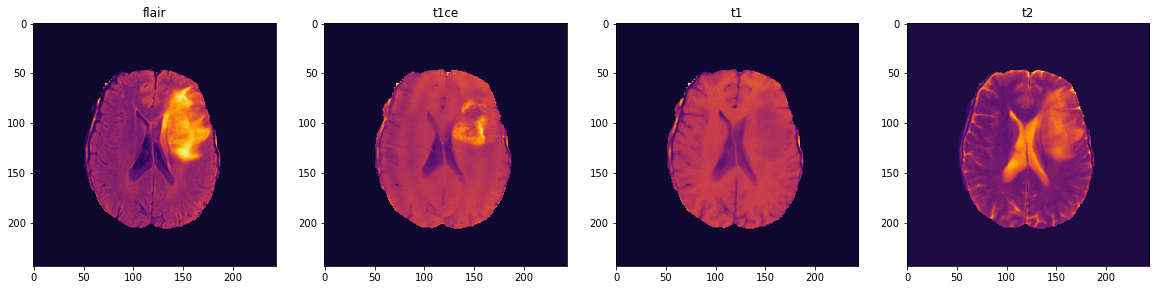

profundidad 80


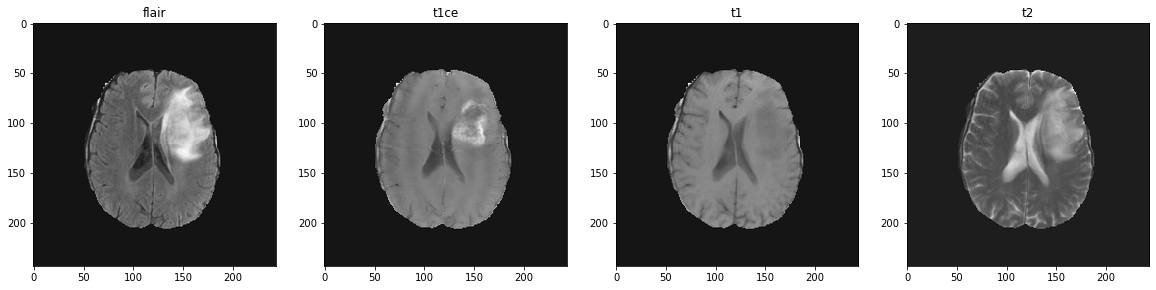

In [6]:
fn.mostrar_img2(img_completo_004,80,"inferno")
fn.mostrar_img2(img_completo_004,80)

## Segmentación de imágenes
1 - Tumor sin realce |
2 - Edema |
4 - Tumor realzado

El archivo de segmentación identifica la precencia de tejido tumoral con tres caracteristicas, tejido tumoral sin realce, edema y tejido tumoral realzado.

profundidad 155
profundidad segmentación 155


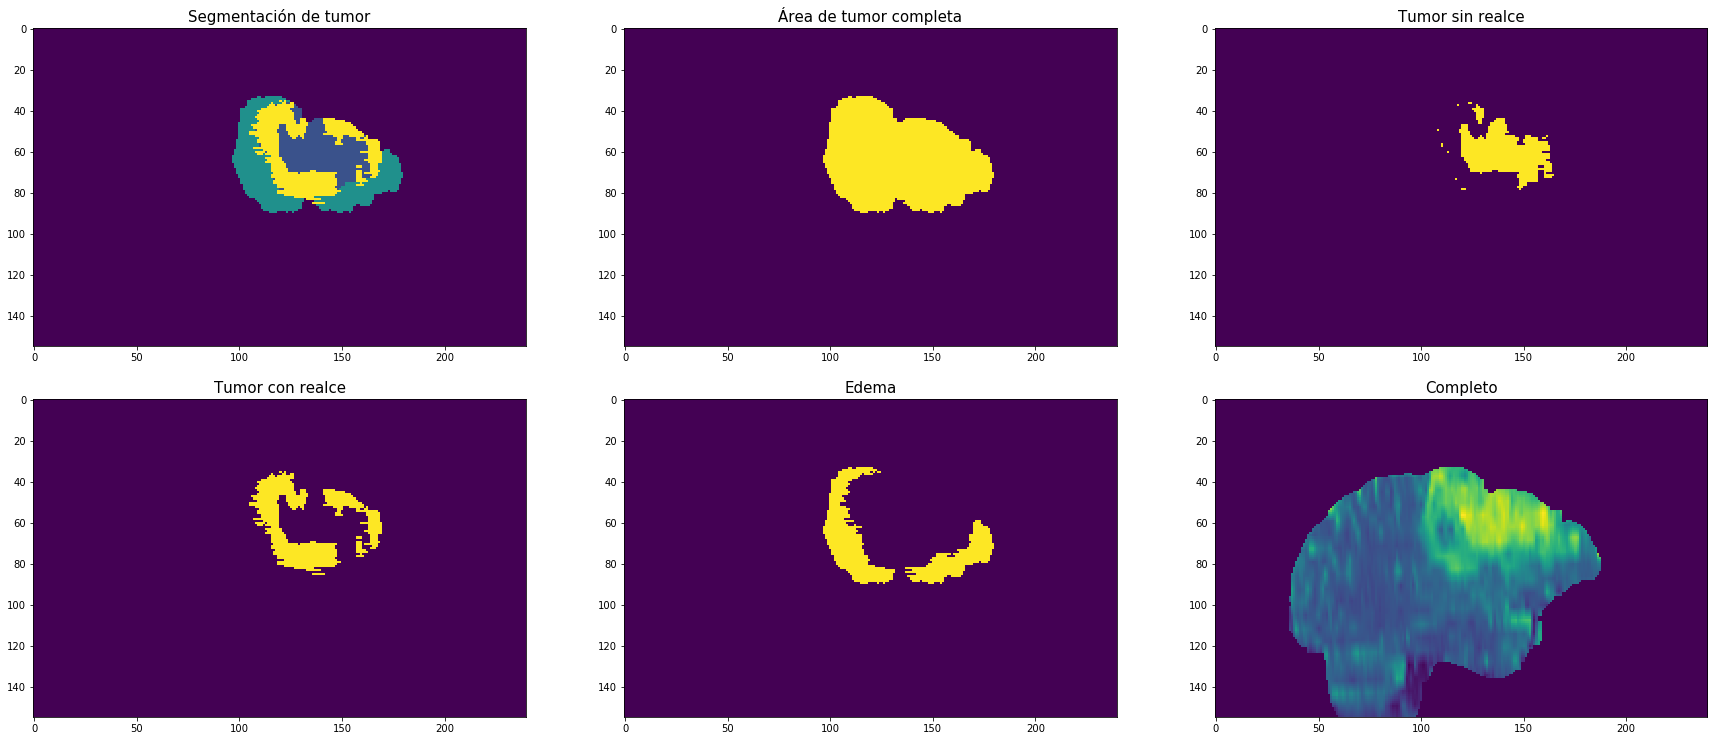

In [7]:
fn.mostrar_seg(img_seg,img_completo_004,155,155)

profundidad 155
profundidad segmentación 80


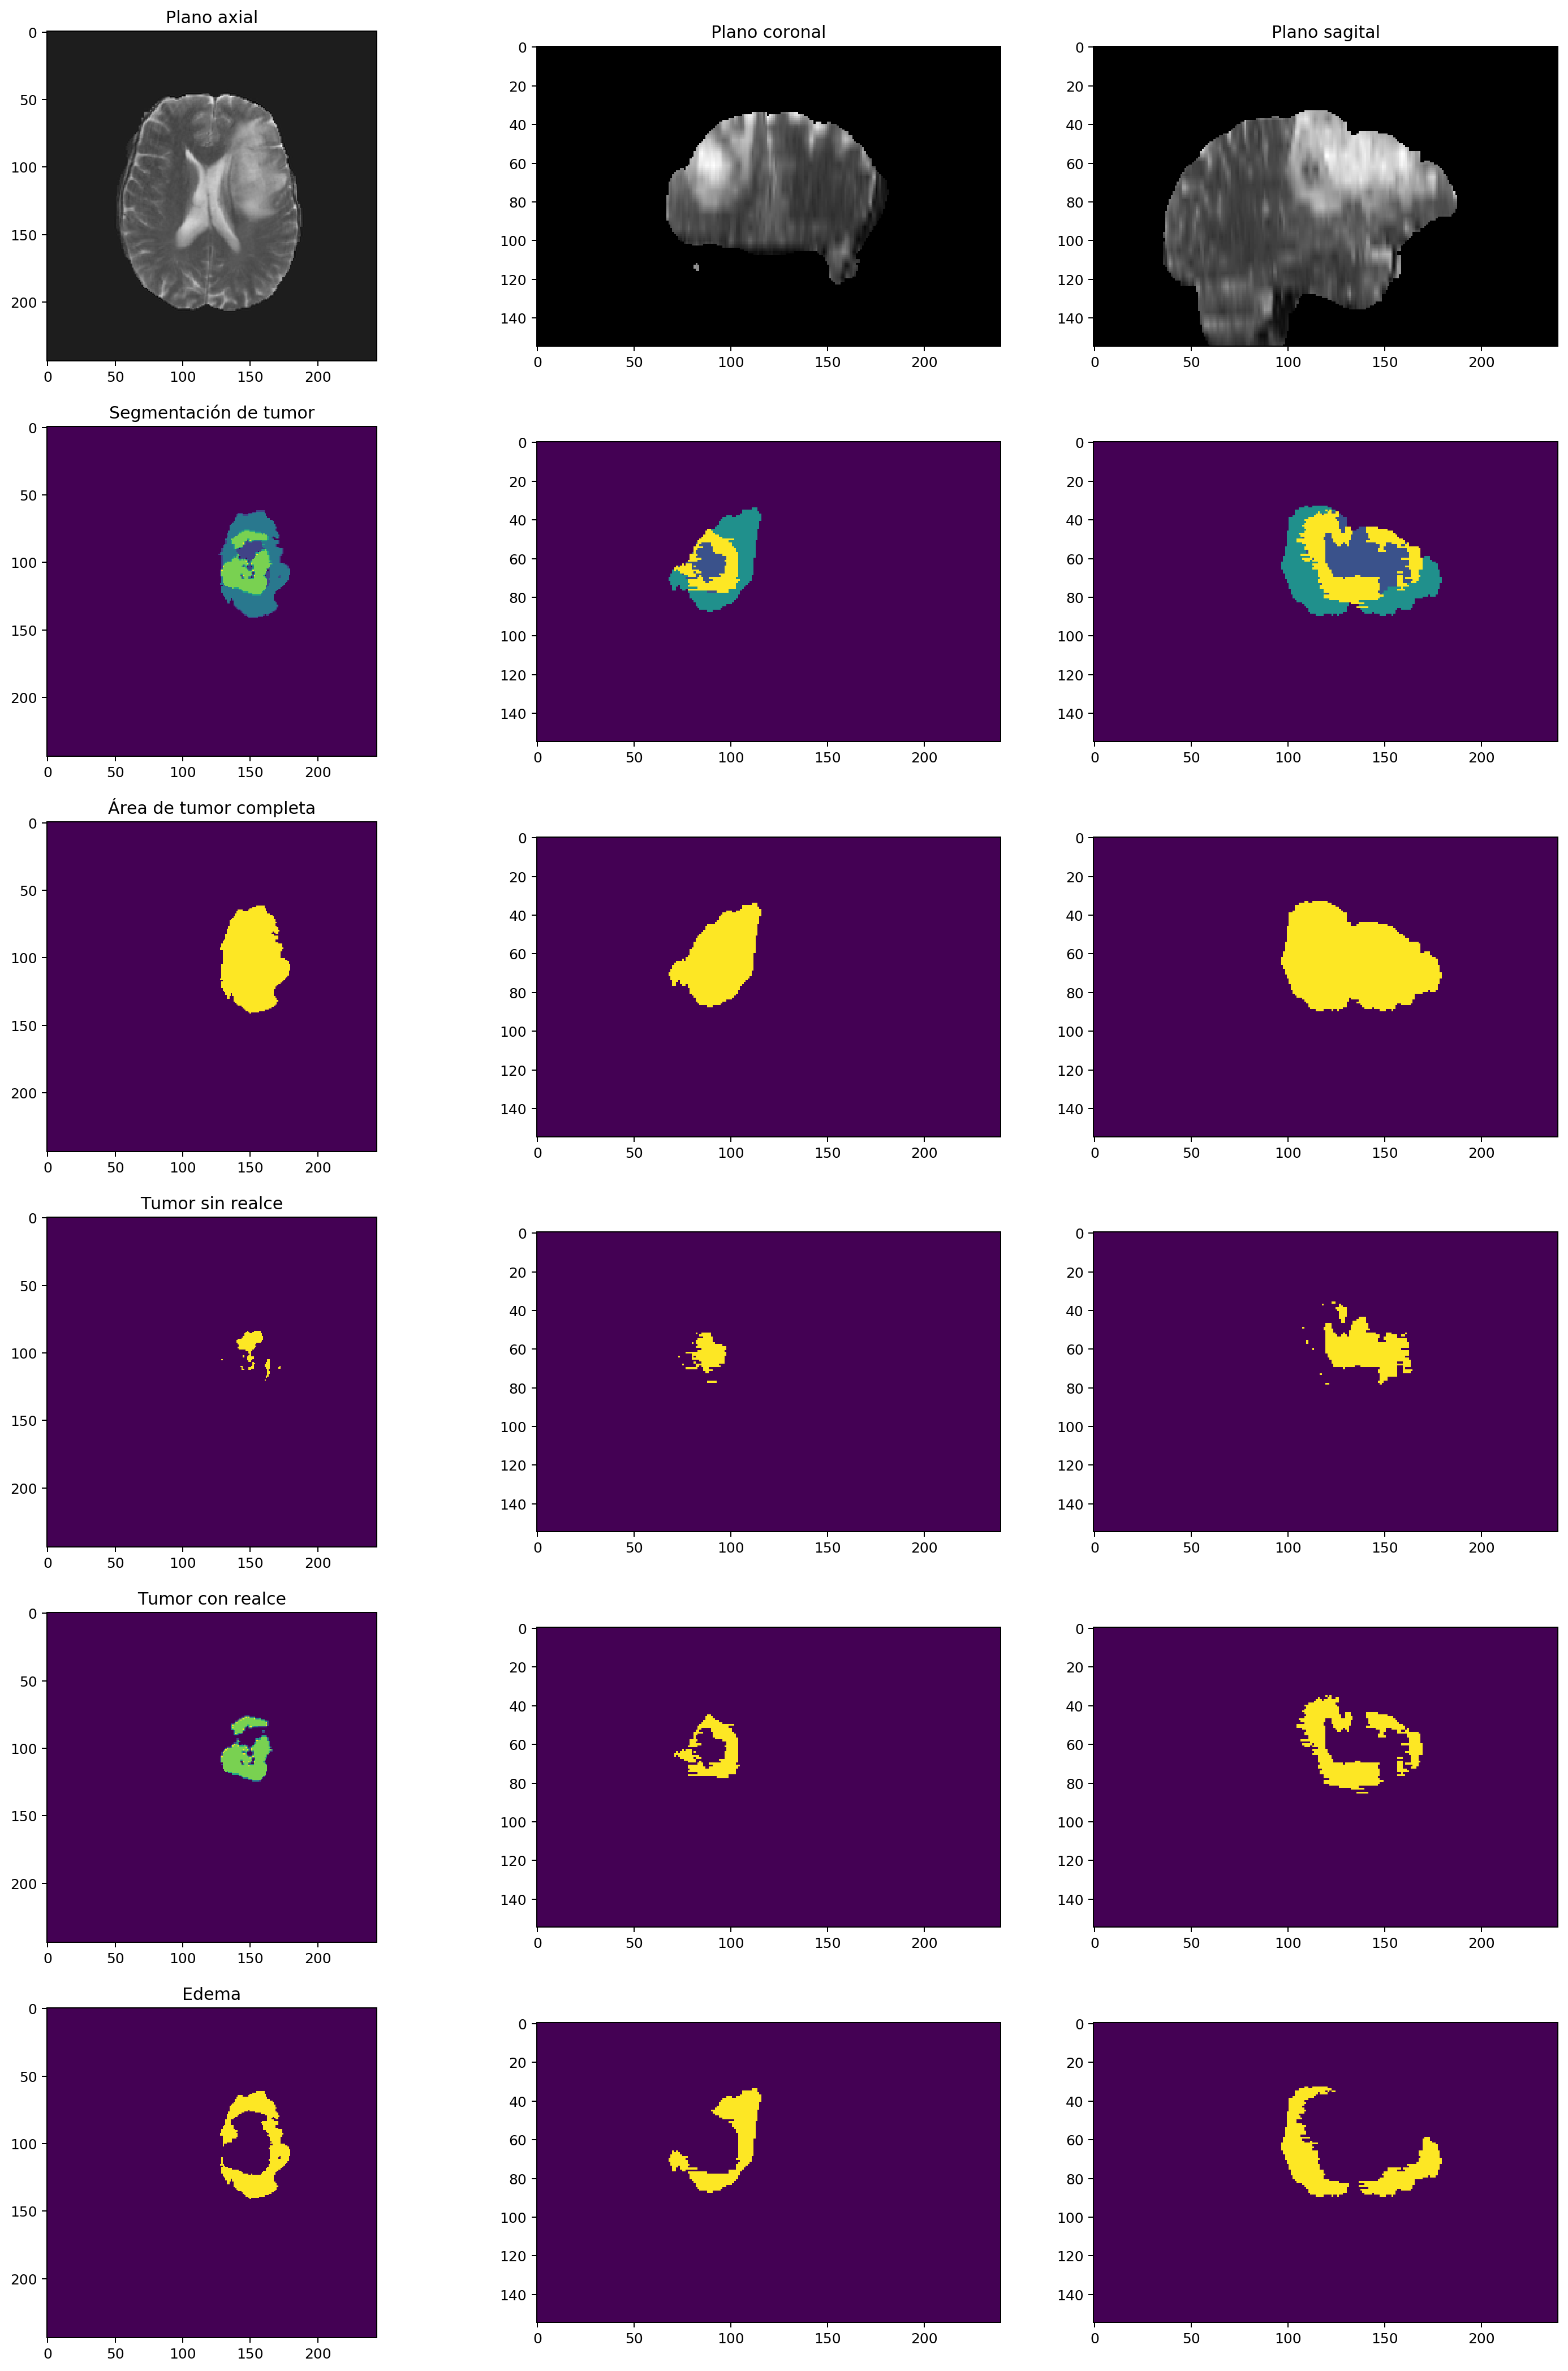

In [8]:
fn.mostrar_seg_planos(img_seg,img_completo_004,155,80)

## Carga de datos para el modelo

#### Para este caso utilizaremos los datos de los archivos de segmentación y las capas flair y t2, auque se pueden utilizar las cinco capas en conjunto

## SELECCIÓN DE DATOS

Debido al volumen seleccionaremos 102 de las carpetas del repositorio  MICCAI_BraTS_2018_Data_Training/HGG

In [14]:
ruta = "data/MICCAI_BraTS_2018_Data_Training/HGG/"
flair_data = fn.to_array(path=ruta, end="**TCIA0*/*flair.nii.gz")
t2_data = fn.to_array(path=ruta, end="**TCIA0*/*t2.nii.gz")
seg_data = fn.seg_to_array(path=ruta, end="**TCIA0*/*seg.nii.gz", label=1)
flair_data.shape

(7140, 1, 128, 128)

Hacemos una concatenación de las capas  flair, t2 para los datos que serán ingresados al modelo como entradas (inputs)

In [15]:
X = np.concatenate((flair_data, t2_data), axis=1)
X.shape, seg_data.shape

((7140, 2, 128, 128), (7140, 1, 128, 128))

### DATOS ENTRENAMIENTO Y VALIDACIÓN

Generamos los grupos de datos para validación y entrenamiento. Posteriormente les damos el formato requerido para el modelo

In [17]:
X_ent, y_ent, X_val, y_val = fn.vcrep_kpart(X, seg_data,k=5)

X_ent = tf.transpose(X_ent, [0, 3, 2, 1])
y_ent = tf.transpose(y_ent, [0, 3, 2, 1])
X_val = tf.transpose(X_val, [0, 3, 2, 1])
y_val = tf.transpose(y_val, [0, 3, 2, 1])

print("Datos de Entrenamiento", X_ent.shape, y_ent.shape)
print("Datos de Validación", X_val.shape, y_val.shape)

2022-06-15 22:38:45.458559: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 748683264 exceeds 10% of free system memory.


Datos de Entrenamiento (5712, 128, 128, 2) (5712, 128, 128, 1)
Datos de Validación (1428, 128, 128, 2) (1428, 128, 128, 1)


### Datos para prueba

In [18]:
ruta = "data/MICCAI_BraTS_2018_Data_Training/HGG/"
flair_prueba = fn.to_array(path=ruta, end="**201_1/*flair.nii.gz")
t2_prueba = fn.to_array(path=ruta, end="**201_1/*t2.nii.gz")
seg_prueba = fn.seg_to_array(path=ruta, end="**201_1/*seg.nii.gz", label=1)
flair_prueba.shape

(70, 1, 128, 128)

In [30]:
X_prueba = np.concatenate((flair_prueba, t2_prueba), axis=1)
X_prueba.shape, seg_prueba.shape

((70, 2, 128, 128), (70, 1, 128, 128))

## Datos de entrada

profundidad 100


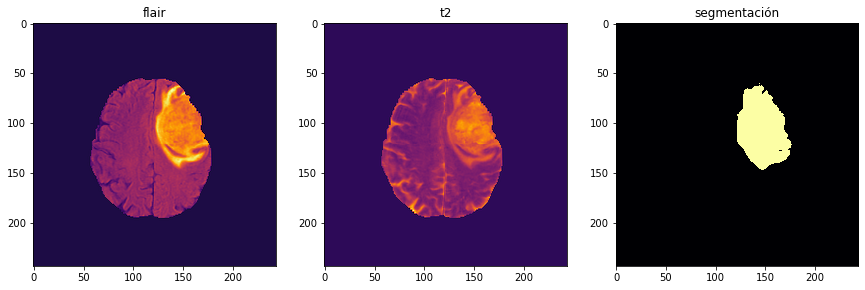

In [31]:
fn.mostrar_img_entradas(img_flair,img_t2,img_seg,100,100,color="inferno")

## Creación de nuestro modelo

In [26]:
model = modelo.unet()

#### Características del modelo UNet

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 1)       65        
                                                                 
Total params: 38,721
Trainable params: 38,465
Non-trainable params: 256
_______________________________________________________

In [18]:
PATH_WEIGHTS = "pesos/UNet/Epoch/"
model_checkpoint = ModelCheckpoint(filepath = PATH_WEIGHTS + "model-{epoch:04d}-{val_loss:.4f}.hdf5", 
                                   monitor = 'val_loss',
                                   verbose = 1, 
                                   save_best_only = False,
                                   save_freq = 'epoch'
                                   )
csv_logger = CSVLogger(PATH_WEIGHTS + "model_log.csv", append=True)

## Ejecución del modelo UNet

In [19]:
model.fit(
    X_ent, 
    y_ent, 
    validation_data=(X_val,y_val), 
    batch_size=32, 
    epochs=15, 
    callbacks=[model_checkpoint,csv_logger])

Epoch 1/15
179/179 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9872
Epoch 1: saving model to pesos/UNet/Epoch/model-0001-0.1046.hdf5
179/179 [==============================] - 257s 1s/step - loss: 0.0387 - accuracy: 0.9872 - val_loss: 0.1046 - val_accuracy: 0.9898
Epoch 2/15
179/179 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9931
Epoch 2: saving model to pesos/UNet/Epoch/model-0002-0.0272.hdf5
179/179 [==============================] - 277s 2s/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.0272 - val_accuracy: 0.9897
Epoch 3/15
179/179 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9935
Epoch 3: saving model to pesos/UNet/Epoch/model-0003-0.0179.hdf5
179/179 [==============================] - 287s 2s/step - loss: 0.0184 - accuracy: 0.9935 - val_loss: 0.0179 - val_accuracy: 0.9935
Epoch 4/15
179/179 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9937
Epoch 4: saving model to 

## GUARDADO DE MODELO ENTRENADO

In [20]:
model.save_weights("data/content/subset_model001.h5")

## CARGA DE MODELO ENTRENADO

In [27]:
model.load_weights("data/content/subset_model001.h5")

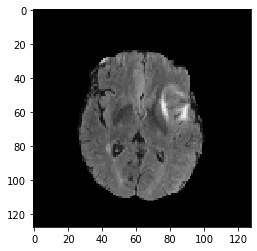

In [41]:
plt.imshow(X_prueba[5][0],cmap='gray');

In [40]:
sample = np.expand_dims(X_prueba[5], axis=0)
sample = tf.transpose(sample, [0, 3, 2, 1])
pred = model.predict(sample)

1/1 [==============================] - 0s 27ms/step


SE AJUSTAN LOS EJES DEL MODELO PARA SU LECTURA

In [34]:
pred = tf.transpose(pred, [0, 3, 2, 1])

## RESULTADOS DE LA PREDICCIÓN

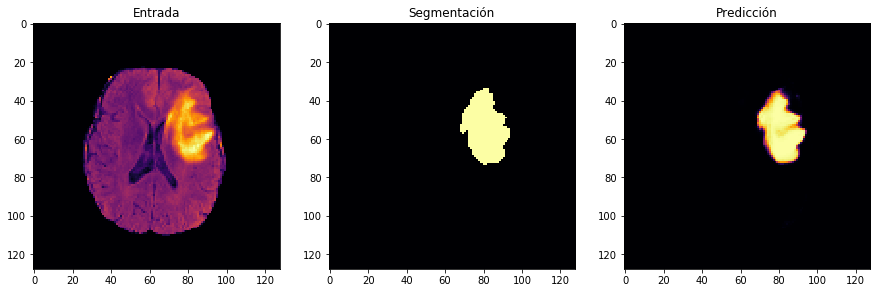

In [35]:
fig = plt.gcf()
fig.set_size_inches(15, 30)
plt.subplot(2,3,1)
plt.title('Entrada')
plt.imshow(X_prueba[15][0],cmap="inferno");

plt.subplot(2,3,2)
plt.title('Segmentación')
plt.imshow(seg_prueba[15][0],cmap="inferno");

plt.subplot(2,3,3)
plt.title('Predicción')
plt.imshow(pred[0][0],cmap="inferno");

plt.show()

1/1 [==============================] - 0s 21ms/step


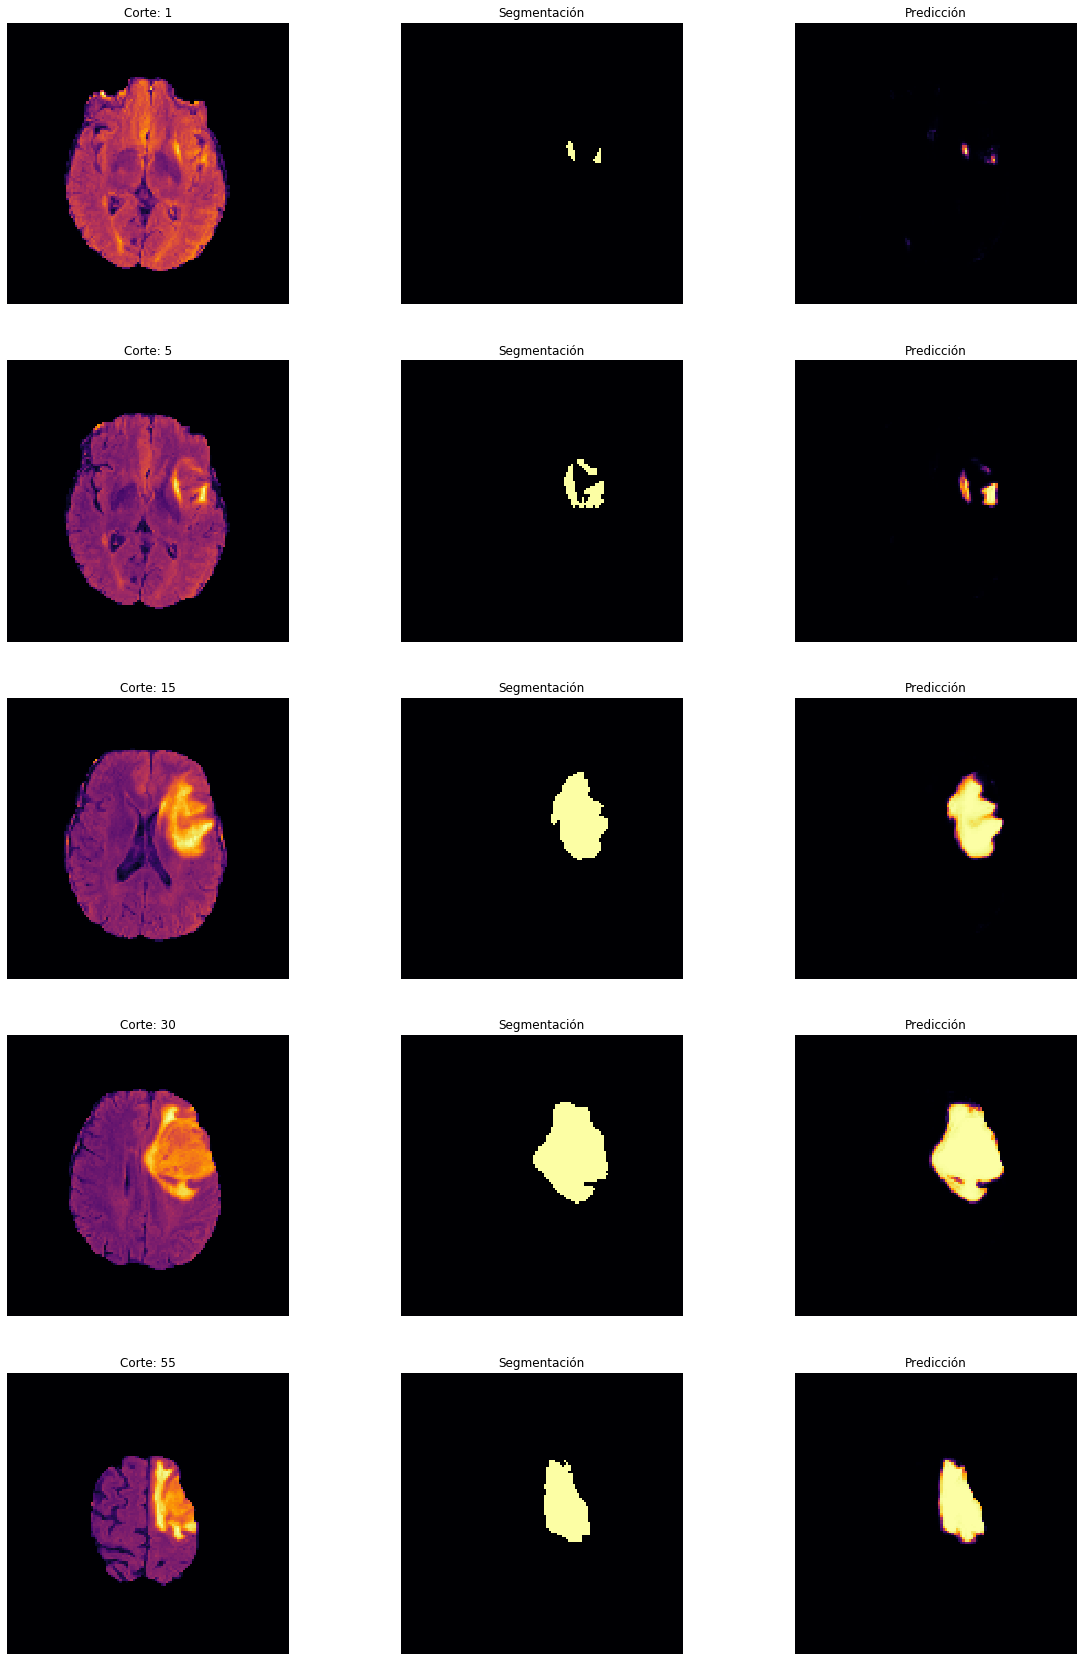

In [54]:
cortes=[1,5,15,30,55]
fig = plt.gcf()
fig.set_size_inches(20, 30)
k=0
for i in range(len(cortes)):
    sample = np.expand_dims(X_prueba[cortes[i]], axis=0)
    sample = tf.transpose(sample, [0, 3, 2, 1])
    pred = model.predict(sample)
    pred = tf.transpose(pred, [0, 3, 2, 1])
    
    titulo = "Corte: "+ str(cortes[i])

    plt.subplot(5,3,k+1)
    plt.title(titulo)
    plt.imshow(X_prueba[cortes[i]][0],cmap="inferno");
    plt.axis('off')

    plt.subplot(5,3,k+2)
    plt.title('Segmentación')
    plt.imshow(seg_prueba[cortes[i]][0],cmap="inferno");
    plt.axis('off')
    
    plt.subplot(5,3,k+3)
    plt.title('Predicción')
    plt.imshow(pred[0][0],cmap="inferno");
    plt.axis('off')
    
    k = k + 3    

plt.show()

## EVALUACIÓN DEL MODELO

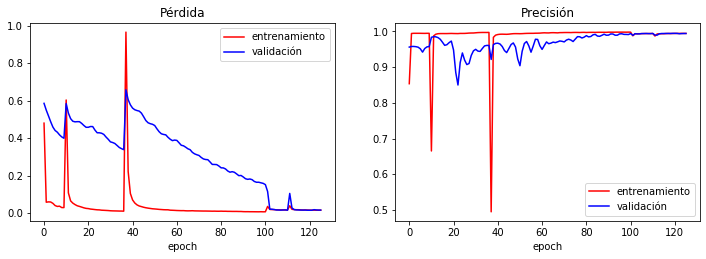

In [13]:
PATH_HISTORY = "pesos/UNet/Epoch/model_log.csv"
history = pd.read_csv(PATH_HISTORY)

fn.grafico_hist(history)

In [51]:
n=len(history['accuracy'])
n1=len(history['val_accuracy'])
n2=len(history['val_loss'])
r=len(history['loss'])
print("Evaluación del Clasificador")
print("Entrenamiento:",sum(history['accuracy'])/n)
print("Validación:",sum(history['val_accuracy'])/n1)

Evaluación del Clasificador
Entrenamiento: 0.9873367160085648
Validación: 0.9695965042189946
